<img src="sf_logo.png" style="width:100px;height:100px"> 

# Player Plan 
### Logan Webb

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, SpectralClustering
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
 
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

ModuleNotFoundError: No module named 'pandas'

In [25]:
# loading statcast data
statcast19 = pd.read_csv("data/Statcast_2019.csv")
statcast20 = pd.read_csv("data/Statcast_2020.csv")

In [69]:
# grouping all Logan Webb instances for the 2019 season
lw19 = statcast19.groupby('player_name').get_group("Logan Webb")

# grouping all Logan Webb instances for the 2020 season
lw20 = statcast20.groupby('player_name').get_group("Logan Webb")

# concatenating Logan Webb 2019 and 2020 seasons
logan_webb = lw19.append(lw20)

# changing 2-Seam Fastballs to Sinkers
logan_webb["pitch_type"] = logan_webb["pitch_type"].replace({"FT":"SI"})
logan_webb["pitch_name"] = logan_webb["pitch_name"].replace({"2-Seam Fastball":"Sinker"})

# new csv with Logan´s data
logan_webb.to_csv("data/lwstatcast.csv")

In [28]:
# loading Logan´s data
lw_data = pd.read_csv("data/lwstatcast.csv")

In [29]:
lw_val_col = lw_data.copy

In [30]:
# selecting columns necessary for this analysis
lw_val_col = lw_data[["pitch_type", "release_speed", "release_pos_x", "release_pos_z", "events", "description", "zone", "stand", "pfx_x",
       "pfx_z", "plate_x", "plate_z", "vx0", "vy0", "vz0", "ax", "ay", "az", "sz_top", "sz_bot",
       "launch_speed", "launch_angle", "effective_speed", "release_spin_rate", "release_extension", "release_pos_y", "pitch_name"]]

### Preparing Data for Clustering

In [32]:
# cols for clustering
sub_col = lw_val_col[["pitch_type", "release_spin_rate", "release_speed", "pfx_x", "pfx_z"]]

# conditions for new category column
def conditions(s):
    if(s["pitch_type"]=="CH"):
        return 0
    elif(s["pitch_type"]=="SL"):
        return 1
    elif(s["pitch_type"]=="FF"):
        return 2
    elif(s["pitch_type"]=="SI"):
        return 3
    else:
        return 4
    
# applying conditions
sub_col["p_type"] = sub_col.apply(conditions, axis=1)

# dropping old column
sub_col.drop("pitch_type", inplace=True, axis=1)

<ipython-input-32-110cd9370d06>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_col["p_type"] = sub_col.apply(conditions, axis=1)
/Users/pau/.pyenv/versions/3.8.5/lib/python3.8/site-packages/pandas/core/frame.py:4162: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [33]:
sub_col.dropna(inplace=True)

<ipython-input-33-72200729f846>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_col.dropna(inplace=True)


### Change Up (CH)

In [34]:
ch_data = sub_col.groupby("p_type").get_group(0)

ch_cols_of_interest = ["release_spin_rate","release_speed","pfx_x", "pfx_z"]

ch_data = ch_data[ch_cols_of_interest]

ch_X = np.array(ch_data)

In [35]:
ch_data.size

1672

In [36]:
ch_sum_of_squared_distances = []
K = range(1,15)
for k in K:
    ch_k_means = KMeans(n_clusters=k)
    ch_model = ch_k_means.fit(ch_X)
    ch_sum_of_squared_distances.append(ch_k_means.inertia_)

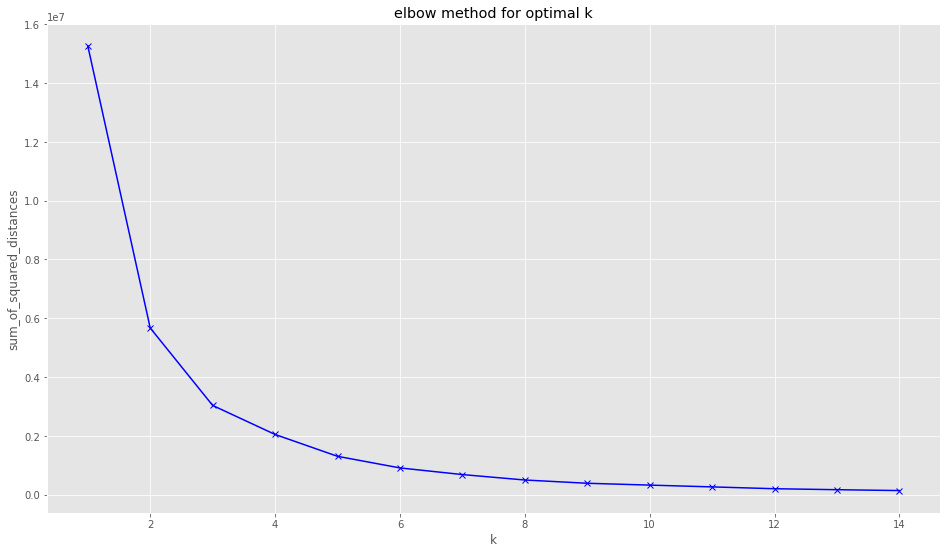

In [37]:
plt.plot(K, ch_sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k')
plt.show()

In [38]:
ch_k_means_2 = KMeans(n_clusters=3)
ch_model = ch_k_means_2.fit(ch_X)
ch_y_hat_2 = ch_k_means_2.predict(ch_X)
ch_labels_2 = ch_k_means_2.labels_
metrics.silhouette_score(ch_X, ch_labels_2, metric = 'euclidean')
metrics.calinski_harabasz_score(ch_X, ch_labels_2)

836.2435900985382

In [39]:
ch_centers = ch_model.cluster_centers_
#function that creates a dataframe with a column for cluster number
def pd_centers(cols_of_interest, centers):
        ch_colNames = list(cols_of_interest)
        ch_colNames.append('prediction')
# Zip with a column called 'prediction' (index)
        ch_Z = [np.append(A, index) for index, A in enumerate(centers)]
# Convert to pandas data frame
        ch_P = pd.DataFrame(ch_Z, columns=ch_colNames)
        ch_P['prediction'] = ch_P['prediction'].astype(int)
        ch_P['count'] = pd.value_counts(ch_k_means_2.labels_)
        return ch_P
ch_P = pd_centers(ch_cols_of_interest, ch_centers)
ch_P

,release_spin_rate,release_speed,pfx_x,pfx_z,prediction,count
0,1492.415301,84.407650,-0.986499,-0.144032,0,183
1,1653.517544,84.887281,-1.056027,-0.128210,1,228
2,2762.714286,84.828571,-1.185714,-0.014286,2,7


### Sinker (SI)

In [40]:
si_data = sub_col.groupby("p_type").get_group(3)

si_cols_of_interest = ["release_spin_rate","release_speed","pfx_x", "pfx_z"]

si_data = si_data[si_cols_of_interest]

si_X = np.array(si_data)

In [41]:
si_sum_of_squared_distances = []
K = range(1,15)
for k in K:
    si_k_means = KMeans(n_clusters=k)
    si_model = si_k_means.fit(si_X)
    si_sum_of_squared_distances.append(si_k_means.inertia_)

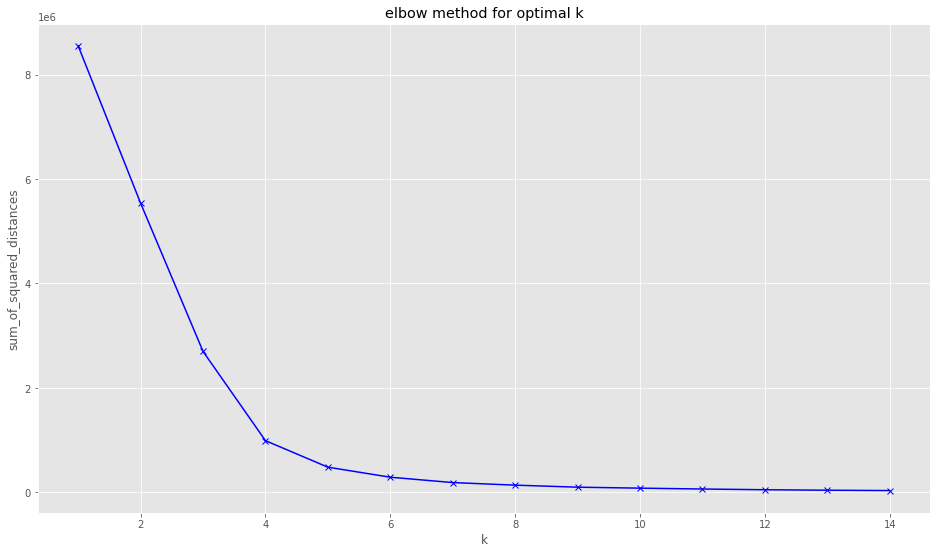

In [42]:
plt.plot(K, si_sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k')
plt.show()

In [43]:
si_k_means_2 = KMeans(n_clusters=4)
si_model = si_k_means_2.fit(si_X)
si_y_hat_2 = si_k_means_2.predict(si_X)
si_labels_2 = si_k_means_2.labels_
metrics.silhouette_score(si_X, si_labels_2, metric = 'euclidean')
metrics.calinski_harabasz_score(si_X, si_labels_2)

549.3410266055334

In [45]:
si_centers = si_model.cluster_centers_
#function that creates a dataframe with a column for cluster number
def pd_centers(cols_of_interest, centers):
        si_colNames = list(cols_of_interest)
        si_colNames.append('prediction')
# Zip with a column called 'prediction' (index)
        si_Z = [np.append(A, index) for index, A in enumerate(centers)]
# Convert to pandas data frame
        si_P = pd.DataFrame(si_Z, columns=si_colNames)
        si_P['prediction'] = si_P['prediction'].astype(int)
        si_P['count'] = pd.value_counts(si_k_means_2.labels_)
        return si_P
si_P = pd_centers(si_cols_of_interest, si_centers)
si_P

,release_spin_rate,release_speed,pfx_x,pfx_z,prediction,count
0,2131.475000,92.078750,-1.434689,0.588906,0,80
1,1020.333333,92.666667,-1.400000,0.400000,1,3
2,1946.791045,91.602239,-1.435168,0.455813,2,134
3,2995.333333,92.733333,-1.333333,0.433333,3,3


### Slider (SL)

In [46]:
sl_data = sub_col.groupby("p_type").get_group(1)

sl_cols_of_interest = ["release_spin_rate","release_speed","pfx_x", "pfx_z"]

sl_data = sl_data[sl_cols_of_interest]

sl_X = np.array(sl_data)

In [100]:
sl_sum_of_squared_distances = []
K = range(1,15)
for k in K:
    sl_k_means = KMeans(n_clusters=k)
    sl_model = sl_k_means.fit(sl_X)
    sl_sum_of_squared_distances.append(sl_k_means.inertia_)

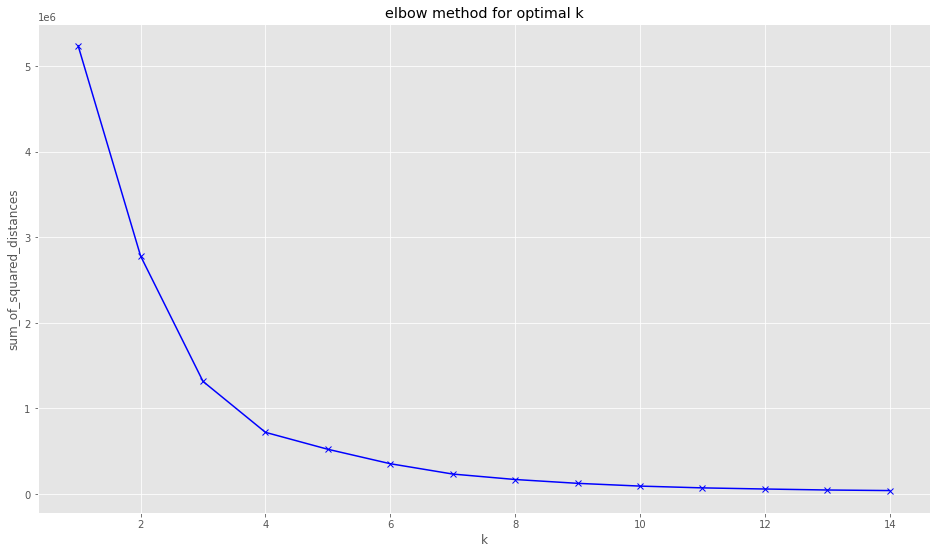

In [101]:
plt.plot(K, sl_sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k')
plt.show()

In [106]:
sl_k_means_2 = KMeans(n_clusters=4)
sl_model = sl_k_means_2.fit(sl_X)
sl_y_hat_2 = sl_k_means_2.predict(sl_X)
sl_labels_2 = sl_k_means_2.labels_
metrics.silhouette_score(sl_X, sl_labels_2, metric = 'euclidean')
metrics.calinski_harabasz_score(sl_X, sl_labels_2)

576.5788272511757

In [107]:
sl_centers = sl_model.cluster_centers_
#function that creates a dataframe with a column for cluster number
def pd_centers(cols_of_interest, centers):
        sl_colNames = list(cols_of_interest)
        sl_colNames.append('prediction')
# Zip with a column called 'prediction' (index)
        sl_Z = [np.append(A, index) for index, A in enumerate(centers)]
# Convert to pandas data frame
        sl_P = pd.DataFrame(sl_Z, columns=sl_colNames)
        sl_P['prediction'] = P['prediction'].astype(int)
        sl_P['count'] = pd.value_counts(sl_k_means_2.labels_)
        return sl_P
sl_P = pd_centers(sl_cols_of_interest, sl_centers)
sl_P

,release_spin_rate,release_speed,pfx_x,pfx_z,prediction,count
0,2731.844828,81.709483,0.964306,-0.117269,0,116
1,2864.897059,82.058824,0.979243,-0.113000,1,68
2,1417.000000,82.800000,1.100000,0.000000,2,1
3,2599.252632,81.316842,0.894334,-0.081833,3,95


### 4-Seam Fastball (FF)

In [47]:
ff_data = sub_col.groupby("p_type").get_group(2)

ff_cols_of_interest = ["release_spin_rate","release_speed","pfx_x", "pfx_z"]

ff_data = ff_data[ff_cols_of_interest]

ff_X = np.array(ff_data)

In [109]:
ff_sum_of_squared_distances = []
K = range(1,15)
for k in K:
    ff_k_means = KMeans(n_clusters=k)
    ff_model = ff_k_means.fit(ff_X)
    ff_sum_of_squared_distances.append(ff_k_means.inertia_)

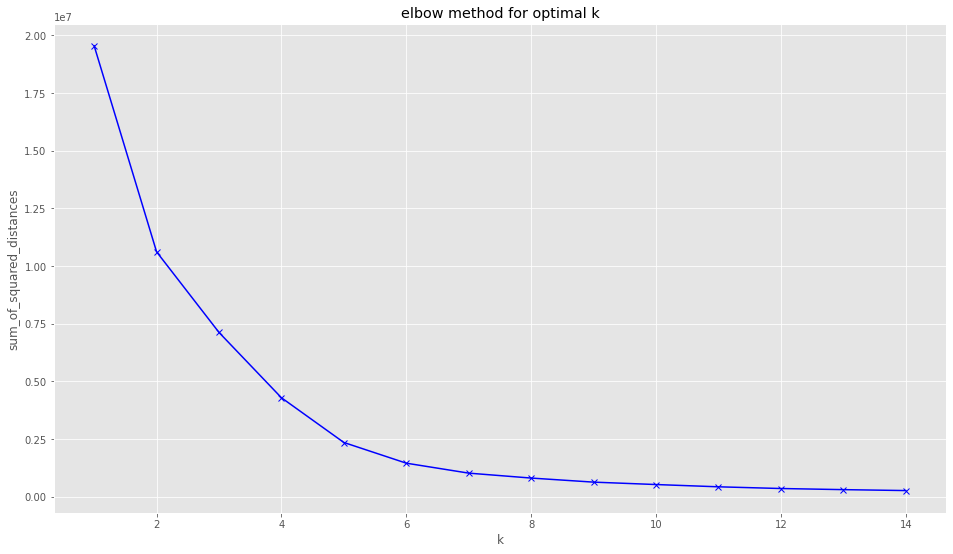

In [110]:
plt.plot(K, ff_sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k')
plt.show()

In [115]:
ff_k_means_2 = KMeans(n_clusters=4)
ff_model = ff_k_means_2.fit(ff_X)
ff_y_hat_2 = ff_k_means_2.predict(ff_X)
ff_labels_2 = ff_k_means_2.labels_
metrics.silhouette_score(ff_X, ff_labels_2, metric = 'euclidean')
metrics.calinski_harabasz_score(ff_X, ff_labels_2)

735.2954749727677

In [116]:
ff_centers = ff_model.cluster_centers_
#function that creates a dataframe with a column for cluster number
def pd_centers(cols_of_interest, centers):
        ff_colNames = list(cols_of_interest)
        ff_colNames.append('prediction')
# Zip with a column called 'prediction' (index)
        ff_Z = [np.append(A, index) for index, A in enumerate(centers)]
# Convert to pandas data frame
        ff_P = pd.DataFrame(ff_Z, columns=ff_colNames)
        ff_P['prediction'] = P['prediction'].astype(int)
        ff_P['count'] = pd.value_counts(ff_k_means_2.labels_)
        return ff_P
ff_P = pd_centers(ff_cols_of_interest, ff_centers)
ff_P

,release_spin_rate,release_speed,pfx_x,pfx_z,prediction,count
0,2083.111748,92.908023,-0.732145,1.018403,0,349
1,2294.383142,93.286590,-0.751294,1.137259,1,261
2,2998.857143,93.542857,-0.742857,1.100000,2,7
3,1374.500000,93.733333,-0.683333,1.150000,3,6


### Cutter (FC)

In [48]:
fc_data = sub_col.groupby("p_type").get_group(4)

fc_cols_of_interest = ["release_spin_rate","release_speed","pfx_x", "pfx_z"]

fc_data = fc_data[fc_cols_of_interest]

fc_X = np.array(fc_data)

In [118]:
fc_sum_of_squared_distances = []
K = range(1,15)
for k in K:
    fc_k_means = KMeans(n_clusters=k)
    fc_model = fc_k_means.fit(fc_X)
    fc_sum_of_squared_distances.append(fc_k_means.inertia_)

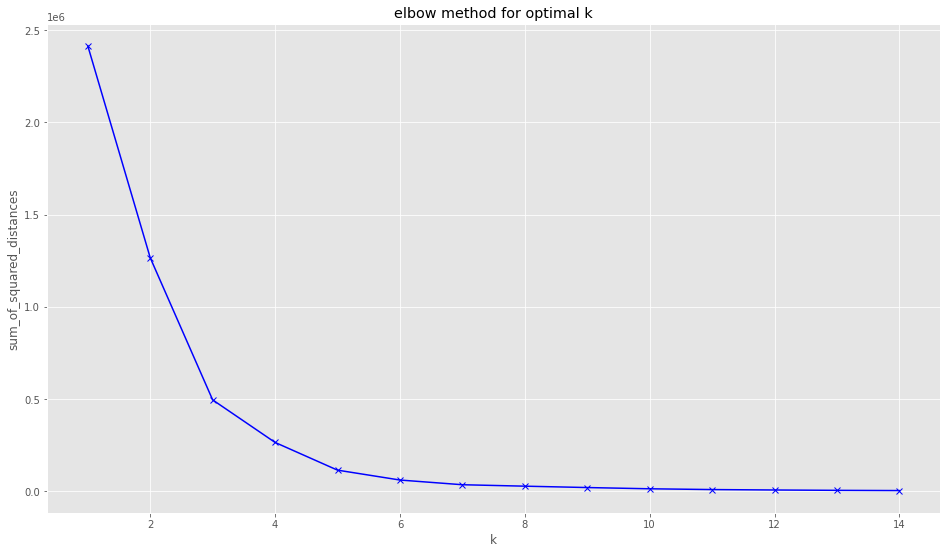

In [119]:
plt.plot(K, fc_sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('elbow method for optimal k')
plt.show()

In [128]:
fc_k_means_2 = KMeans(n_clusters=4)
fc_model = fc_k_means_2.fit(fc_X)
fc_y_hat_2 = fc_k_means_2.predict(fc_X)
fc_labels_2 = fc_k_means_2.labels_
metrics.silhouette_score(fc_X, fc_labels_2, metric = 'euclidean')
metrics.calinski_harabasz_score(fc_X, fc_labels_2)

127.3835319119095

In [129]:
fc_centers = fc_model.cluster_centers_
#function that creates a dataframe with a column for cluster number
def pd_centers(cols_of_interest, centers):
        fc_colNames = list(cols_of_interest)
        fc_colNames.append('prediction')
# Zip with a column called 'prediction' (index)
        fc_Z = [np.append(A, index) for index, A in enumerate(centers)]
# Convert to pandas data frame
        fc_P = pd.DataFrame(fc_Z, columns=fc_colNames)
        fc_P['prediction'] = P['prediction'].astype(int)
        fc_P['count'] = pd.value_counts(fc_k_means_2.labels_)
        return fc_P
fc_P = pd_centers(fc_cols_of_interest, fc_centers)
fc_P

,release_spin_rate,release_speed,pfx_x,pfx_z,prediction,count
0,2306.12,90.344,-0.116,0.684,0,25
1,3106.00,89.700,0.050,0.700,1,2
2,2450.40,90.645,-0.115,0.695,2,20
3,1912.25,91.175,-0.200,0.675,3,4


## Outcome analysis by pitch subgroup

In [50]:
outcomes = lw_val_col.copy()
len(outcomes)

1674

### 4-Seam Fastball

In [9]:
ff_outcome = outcomes.groupby("pitch_type").get_group("FF")

In [311]:
ff1_outcome = ff_outcome.query("release_spin_rate <= 2083 and release_speed <= 92.91")
ff2_outcome = ff_outcome.query("release_spin_rate >= 2294 and release_speed >= 93.29")

#### Swinging Strike % (the percentage of all pitches thrown of that kind that generate swings and misses)

In [312]:
# FF1 sub type
def swingingStrike(pitch_outcome, subpitch_outcome):
    
    ss =["swinging_strike"]

    ff1_ss = subpitch_outcome.query("description in @ ss")

    return len(ff1_ss)/len(pitch_outcome)*100

swingingStrike(ff_outcome, ff1_outcome)

# FF2 sub type

swingingStrike(ff_outcome, ff2_outcome)

# between FF1_FF2

0.15822784810126583

#### Exit Velo

In [274]:
ff1_outcome["launch_speed"].mean()
ff2_outcome["launch_speed"].mean()

86.64499999999998

#### Launch Angle > 40º

In [306]:
def launchAngle40(la_outcome):
    la40 = la_outcome.query("launch_angle > 40")
    return len(la40)/len(la_outcome)*100

#### Launch Angle < 0º

In [307]:
def launchAngle0(la_outcome):
    la0 = la_outcome.query("launch_angle < 0")
    return len(la0)/len(la_outcome)*100

In [309]:
launchAngle0(ff2_outcome)

4.6875

### Change Up

In [14]:
ch_outcome = outcomes.groupby("pitch_type").get_group("CH")
len(ch_outcome)

443

In [340]:
ch1_outcome = ch_outcome.query("release_spin_rate <= 1504")
ch2_outcome = ch_outcome.query("release_spin_rate >= 1665")

In [341]:
# Swing Strike

def swingingStrike(pitch_outcome, subpitch_outcome):
    
    ss =["swinging_strike"]

    pitch_ss = subpitch_outcome.query("description in @ ss")

    return len(pitch_ss)/len(pitch_outcome)*100

In [342]:
swingingStrike(ch_outcome, ch1_outcome)

2.9345372460496613

In [343]:
swingingStrike(ch_outcome, ch2_outcome)

3.3860045146726865

In [344]:
# Exit Velo

print(ch1_outcome["launch_speed"].mean())
print(ch2_outcome["launch_speed"].mean())

85.93928571428572
90.995


In [ ]:
# Launch Angle 40
def launchAngle40(la_outcome):
    la40 = la_outcome.query("launch_angle > 40")
    return len(la40)/len(la_outcome)*100

# Launch Angle 0 
def launchAngle0(la_outcome):
    la0 = la_outcome.query("launch_angle < 0")
    return len(la0)/len(la_outcome)*100

In [345]:
launchAngle40(ch1_outcome)

1.0869565217391304

In [346]:
launchAngle40(ch2_outcome)

5.555555555555555

In [348]:
launchAngle0(ch1_outcome)

14.130434782608695

In [349]:
launchAngle0(ch2_outcome)

7.777777777777778

### Sinker

In [51]:
si_outcome = outcomes.groupby("pitch_type").get_group("SI")
len(si_outcome)

234

In [53]:
si1_outcome = si_outcome.query("release_spin_rate <= 1946")
si2_outcome = si_outcome.query("release_spin_rate >= 2131")

In [54]:
# Swing Strike

def swingingStrike(pitch_outcome, subpitch_outcome):
    
    ss =["swinging_strike"]

    pitch_ss = subpitch_outcome.query("description in @ ss")

    return len(pitch_ss)/len(pitch_outcome)*100

In [55]:
swingingStrike(si_outcome, si1_outcome)

0.4273504273504274

In [56]:
swingingStrike(si_outcome, si2_outcome)

0.8547008547008548

In [57]:
# Exit Velo

print(si1_outcome["launch_speed"].mean())
print(si2_outcome["launch_speed"].mean())

81.65714285714286
88.58181818181818


In [58]:
# Launch Angle 40
def launchAngle40(la_outcome):
    la40 = la_outcome.query("launch_angle > 40")
    return len(la40)/len(la_outcome)*100

# Launch Angle 0 
def launchAngle0(la_outcome):
    la0 = la_outcome.query("launch_angle < 0")
    return len(la0)/len(la_outcome)*100

In [59]:
launchAngle40(si1_outcome)

0.0

In [60]:
launchAngle40(si2_outcome)

5.405405405405405

In [61]:
launchAngle0(si1_outcome)

22.413793103448278

In [62]:
launchAngle0(si2_outcome)

13.513513513513514

### Slider

In [16]:
sl_outcome = outcomes.groupby("pitch_type").get_group("SL")
len(sl_outcome)

312

In [86]:
sl1_outcome = sl_outcome.query("release_spin_rate <= 2732 and release_spin_rate < 2865")
sl2_outcome = sl_outcome.query("release_spin_rate >= 2865")
sl3_outcome = sl_outcome.query("release_spin_rate <= 2599")

In [385]:
swingingStrike(sl_outcome, sl1_outcome)

3.205128205128205

In [386]:
swingingStrike(sl_outcome, sl2_outcome)

1.282051282051282

In [387]:
swingingStrike(sl_outcome, sl3_outcome)

1.282051282051282

In [390]:
# Exit Velo

print(sl1_outcome["launch_speed"].mean())
print(sl2_outcome["launch_speed"].mean())
print(sl3_outcome["launch_speed"].mean())

83.75294117647059
70.03333333333335
87.15


In [391]:
launchAngle40(sl1_outcome)

5.228758169934641

In [392]:
launchAngle40(sl2_outcome)

0.0

In [393]:
launchAngle40(sl3_outcome)

10.0

In [394]:
launchAngle0(sl1_outcome)

8.49673202614379

In [395]:
launchAngle0(sl2_outcome)

7.4074074074074066

In [396]:
launchAngle0(sl3_outcome)

0.0

### Cutter

In [17]:
fc_outcome = outcomes.groupby("pitch_type").get_group("FC")
len(fc_outcome)

53

In [397]:
fc1_outcome = fc_outcome.query("release_spin_rate <= 2306")
fc2_outcome = fc_outcome.query("release_spin_rate >= 2450")

In [400]:
swingingStrike(fc_outcome, fc1_outcome)

3.7735849056603774

In [401]:
swingingStrike(fc_outcome, fc2_outcome)

1.8867924528301887

In [402]:
# Exit Velo

print(fc1_outcome["launch_speed"].mean())
print(fc2_outcome["launch_speed"].mean())

79.0
76.95


In [403]:
launchAngle40(fc1_outcome)

0.0

In [404]:
launchAngle40(fc2_outcome)

15.384615384615385

In [405]:
launchAngle0(fc1_outcome)

0.0

In [406]:
launchAngle0(fc2_outcome)

0.0

### Release Possition

In [80]:
print("4-Seam Fastball: ", ff_outcome["release_pos_y"].median())
print("Change Up: ",ch_outcome["release_pos_y"].median())
print("Slider: ",sl_outcome["release_pos_y"].median())
print("Sinker: ",si_outcome["release_pos_y"].median())
print("Cutter: ",fc_outcome["release_pos_y"].median())

4-Seam Fastball:  54.0094
Change Up:  54.0177
Slider:  54.229150000000004
Sinker:  54.03805
Cutter:  54.02


In [81]:
print("4-Seam Fastball: ", ff_outcome["release_pos_x"].median())
print("Change Up: ",ch_outcome["release_pos_x"].median())
print("Slider: ",sl_outcome["release_pos_x"].median())
print("Sinker: ",si_outcome["release_pos_x"].median())
print("Cutter: ",fc_outcome["release_pos_x"].median())

4-Seam Fastball:  -1.8591
Change Up:  -2.1681
Slider:  -2.0059
Sinker:  -2.04
Cutter:  -2.15


In [79]:
print("4-Seam Fastball: ", ff_outcome["release_pos_z"].median())
print("Change Up: ",ch_outcome["release_pos_z"].median())
print("Slider: ",sl_outcome["release_pos_z"].median())
print("Sinker: ",si_outcome["release_pos_z"].median())
print("Cutter: ",fc_outcome["release_pos_z"].median())

4-Seam Fastball:  5.54
Change Up:  5.3999
Slider:  5.44045
Sinker:  5.45945
Cutter:  5.44


### AVG Velo (MPH)

In [77]:
print("4-Seam Fastball: ", ff_outcome["release_speed"].median())
print("Change Up: ",ch_outcome["release_speed"].median())
print("Slider: ",sl_outcome["release_speed"].median())
print("Sinker: ",si_outcome["release_speed"].median())
print("Cutter: ",fc_outcome["release_speed"].median())

4-Seam Fastball:  93.2
Change Up:  84.8
Slider:  81.7
Sinker:  91.9
Cutter:  90.4


### AVG Spin Rate (RPM)

In [76]:
print("4-Seam Fastball: ", ff_outcome["release_spin_rate"].median())
print("Change Up: ",ch_outcome["release_spin_rate"].median())
print("Slider: ",sl_outcome["release_spin_rate"].median())
print("Sinker: ",si_outcome["release_spin_rate"].median())
print("Cutter: ",fc_outcome["release_spin_rate"].median())

4-Seam Fastball:  2167.0
Change Up:  1582.0
Slider:  2715.0
Sinker:  2008.0
Cutter:  2356.0


In [ ]:
AVG. MLB RPM

FB 2200
SL 2400
CH 1800

Bauer Units

FB 23-25
SL 28-30

In [78]:
# Horizontal Movement

print("4-Seam Fastball: ", ff_outcome["pfx_x"].median())
print("Change Up: ",ch_outcome["pfx_x"].median())
print("Slider: ",sl_outcome["pfx_x"].median())
print("Sinker: ",si_outcome["pfx_x"].median())
print("Cutter: ",fc_outcome["pfx_x"].median())

# Vertical Movement
print("4-Seam Fastball: ", ff_outcome["pfx_z"].median())
print("Change Up: ",ch_outcome["pfx_z"].median())
print("Slider: ",sl_outcome["pfx_z"].median())
print("Sinker: ",si_outcome["pfx_z"].median())
print("Cutter: ",fc_outcome["pfx_z"].median())

4-Seam Fastball:  -0.70935
Change Up:  -1.0
Slider:  0.9540500000000001
Sinker:  -1.4
Cutter:  -0.1
4-Seam Fastball:  1.1
Change Up:  -0.1763
Slider:  -0.1
Sinker:  0.5
Cutter:  0.7
